<a href="https://colab.research.google.com/github/chris20834/AI-Summer-Camp/blob/main/GAN_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1. 安裝必要套件

In [ ]:
#!pip install torch torchvision matplotlib

# Step 2. 數據集下載與遮罩函數

In [4]:
import torch  # 匯入 PyTorch 主套件，用於 tensor 運算與神經網路
from torchvision import datasets, transforms  # 匯入 torchvision 的資料集與資料預處理模組
from torch.utils.data import DataLoader  # 匯入 DataLoader，用於批次資料載入
import matplotlib.pyplot as plt  # 匯入 matplotlib，用於畫圖顯示

# 定義一個資料轉換：將圖片轉為 Tensor 格式（0~1，且多增加一個 channel 維度）
transform = transforms.ToTensor()

# 載入 MNIST 手寫數字訓練資料集
# root: 資料存放路徑
# train=True: 使用訓練集
# download=True: 如果沒有資料就下載
# transform=transform: 圖片先做 ToTensor 處理
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 建立 DataLoader，設定 batch 大小為 64，並在每個 epoch 隨機打亂
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# 定義遮罩函式，將圖片中央的正方形區塊設為 0（黑色遮罩）
def mask_center(imgs, size=14):
    imgs = imgs.clone()  # 複製一份，不修改原 tensor
    c = imgs.size(2) // 2  # 取得圖片中心點座標（以height為例：28//2=14）
    l = size // 2  # 遮罩區塊半徑（例如size=14時，l=7）
    # 遮罩中央區塊：[中心-l, 中心+l)，同時套用於高度和寬度
    imgs[:, :, c-l:c+l, c-l:c+l] = 0
    return imgs  # 回傳加上中央遮罩的新圖片張量

# Step 3. 建立 Generator & Discriminator

In [5]:
import torch.nn as nn

# Generator：UNet 結構的簡單實作，包含 Encoder、Decoder 和 skip connection
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: 兩層卷積，逐步下採樣
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # 第一層卷積，輸入通道1，輸出64，kernel=4, stride=2, padding=1
            nn.ReLU()                   # 啟用函數
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1), # 第二層卷積，輸入64，輸出128
            nn.ReLU()
        )
        # Decoder: 兩層反卷積（上採樣）
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 第一層反卷積，從128回到64，output size 14x14
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 4, 2, 1),   # 最後一層反卷積，輸入128(=64+64)，輸出1通道（灰階），output 28x28
            nn.Tanh()  # 將輸出壓到 [-1, 1]，適合生成對抗網路的output
        )

    def forward(self, x):
        e1 = self.enc1(x)           # 輸入x，經第一層encoder，shape: (batch, 64, 14, 14)
        e2 = self.enc2(e1)          # 經第二層encoder，shape: (batch, 128, 7, 7)
        d1 = self.dec1(e2)          # decoder第一層，up-sample到 (batch, 64, 14, 14)
        d1_cat = torch.cat([e1, d1], dim=1)  # 與 encoder1 的特徵圖做 channel 維度串接 (skip connection)，shape: (batch, 128, 14, 14)
        out = self.dec2(d1_cat)     # 經最後一層反卷積還原至 (batch, 1, 28, 28)
        return out

# Discriminator：簡單的卷積分類器
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),      # 第一層卷積，下採樣，輸出 shape (batch, 64, 4, 4)
            nn.LeakyReLU(0.2),              # LeakyReLU 啟用函數
            nn.Conv2d(64, 128, 4, 2, 1),    # 第二層卷積，下採樣，輸出 shape (batch, 128, 2, 2)
            nn.LeakyReLU(0.2),
            nn.Flatten(),                   # 展平成一維
            nn.Linear(128*2*2, 1),          # 全連接層，輸入維度512(=128*2*2)，輸出1（真或假）
            nn.Sigmoid()                    # Sigmoid輸出為0~1間，代表"真實"的機率
        )
    def forward(self, x):
        return self.main(x)  # 前向傳播，傳入圖片，回傳為真的機率

# Step 4. 訓練（僅2個epoch，快速測試）

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 建立 UNetGenerator 和 Discriminator，分別丟到 GPU（如果有）或 CPU
G, D = UNetGenerator().to(device), Discriminator().to(device)
loss_fn = nn.BCELoss()   # 二元交叉熵，判別器用於區分真偽
l1_loss = nn.L1Loss()    # L1 損失（像素差異），鼓勵生成貼近真實

# 建立 Adam optimizer，分別給 G 與 D
opt_G = torch.optim.Adam(G.parameters(), lr=2e-4)
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4)

# 訓練 2 個 epoch
for epoch in range(2):
    for imgs, _ in train_loader:   # 取出每一個 batch（imgs shape: [batch, 1, 28, 28]）
        imgs = imgs.to(device)     # 放到指定運算裝置
        masked = mask_center(imgs, size=8)  # 把中央 8x8 遮起來，模擬修復任務

        # 只拿中央 8x8 區塊作為修復目標（ground truth）
        real = imgs[:, :, 10:18, 10:18]
        # Generator 修補後的結果，同樣只拿中央 8x8 區塊
        fake = G(masked)[:, :, 10:18, 10:18]

        # === 訓練 Discriminator ===
        real_labels = torch.ones(imgs.size(0), 1, device=device)   # 真圖標記為 1
        fake_labels = torch.zeros(imgs.size(0), 1, device=device)  # 假圖標記為 0
        out_real = D(real)                 # D 判斷真圖
        out_fake = D(fake.detach())        # D 判斷假圖（detach 保證不傳遞梯度到 G）
        loss_D = (loss_fn(out_real, real_labels) + loss_fn(out_fake, fake_labels)) / 2  # 判別器損失為真假平均
        opt_D.zero_grad(); loss_D.backward(); opt_D.step()  # 反向傳播並更新 D

        # === 訓練 Generator ===
        out_fake = D(fake)  # 用最新 G 結果再判斷一次
        # Generator 損失 = 欺騙 D 的 loss + L1（像素）損失（權重 10 可調整）
        loss_G = loss_fn(out_fake, real_labels) + 10 * l1_loss(fake, real)
        opt_G.zero_grad(); loss_G.backward(); opt_G.step()  # 反向傳播並更新 G

    # 每個 epoch 輸出一次 loss
    print(f"Epoch {epoch+1}/2 | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")


Epoch 1/2 | Loss_D: 0.6487 | Loss_G: 3.0212
Epoch 2/2 | Loss_D: 0.6288 | Loss_G: 2.5088


# Step 5. 展示修復效果

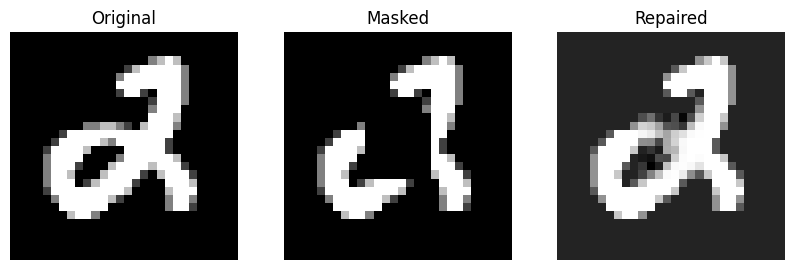

In [16]:
# 從訓練資料中隨機取出一個 batch，並只用第一張圖做測試
imgs, _ = next(iter(train_loader))
test_img = imgs[0:1].to(device)  # 取出第 0 張圖，shape: [1, 1, 28, 28]

# 用和訓練相同的遮罩方式，遮蔽中央 8x8 區塊
masked = mask_center(test_img, size=8)

with torch.no_grad():  # 測試時不用計算梯度（節省運算資源）
    output = G(masked).cpu()  # 將遮罩圖丟到 Generator，產生修復圖，並移到 CPU
    repaired = masked.cpu().clone()  # 複製遮罩圖當基底
    # 只用 Generator 的 output 取代中央 8x8 區塊，其餘維持原遮罩圖
    repaired[:, :, 10:18, 10:18] = output[:, :, 10:18, 10:18]

plt.figure(figsize=(10,3))
# 顯示原圖
plt.subplot(1,3,1)
plt.imshow(test_img.cpu()[0][0], cmap='gray')
plt.title('Original')
plt.axis('off')
# 顯示遮罩圖（中央 8x8 已遮蔽）
plt.subplot(1,3,2)
plt.imshow(masked.cpu()[0][0], cmap='gray')
plt.title('Masked')
plt.axis('off')
# 顯示修復圖（中央區塊已用 Generator 修補）
plt.subplot(1,3,3)
plt.imshow(repaired[0][0], cmap='gray')
plt.title('Repaired')
plt.axis('off')
plt.show()


# Step 6. 修復自己提供的照片

In [11]:
from google.colab import files
uploaded = files.upload()  # 選擇你的手寫數字 PNG 或 JPG 檔案

Saving 9.png to 9.png


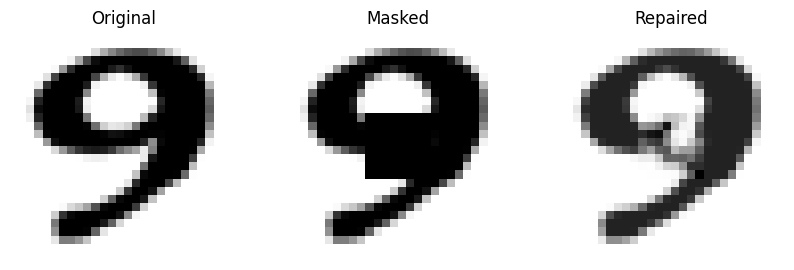

In [14]:
from PIL import Image
#import torchvision.transforms as T
#import torch

# 讀取圖片（檔名請改成你剛上傳的）
img = Image.open('9.png').convert('L')  # 'L' 代表灰階
img = img.resize((28,28))  # 若不是28x28，自動調整
transform = transforms.ToTensor()   # 轉成 tensor，shape: [1,28,28]，範圍 [0,1]
img_tensor = transform(img).unsqueeze(0)  # 增加 batch 維，shape: [1,1,28,28]

# 若你的網路在 GPU，需放到同一裝置
test_img = img_tensor.to(device)

# 用和訓練相同的遮罩方式，遮蔽中央 8x8 區塊
masked = mask_center(test_img, size=8)

with torch.no_grad():  # 測試時不用計算梯度（節省運算資源）
    output = G(masked).cpu()  # 將遮罩圖丟到 Generator，產生修復圖，並移到 CPU
    repaired = masked.cpu().clone()  # 複製遮罩圖當基底
    # 只用 Generator 的 output 取代中央 8x8 區塊，其餘維持原遮罩圖
    repaired[:, :, 10:18, 10:18] = output[:, :, 10:18, 10:18]

plt.figure(figsize=(10,3))
# 顯示原圖
plt.subplot(1,3,1)
plt.imshow(test_img.cpu()[0][0], cmap='gray')
plt.title('Original')
plt.axis('off')
# 顯示遮罩圖（中央 8x8 已遮蔽）
plt.subplot(1,3,2)
plt.imshow(masked.cpu()[0][0], cmap='gray')
plt.title('Masked')
plt.axis('off')
# 顯示修復圖（中央區塊已用 Generator 修補）
plt.subplot(1,3,3)
plt.imshow(repaired[0][0], cmap='gray')
plt.title('Repaired')
plt.axis('off')
plt.show()